In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [3]:
import numpy as np
import torch
import json
from equistore import Labels, TensorBlock, TensorMap
from torch_builder import TensorBuilder
import ase.io
from itertools import product
from torch_cg import ClebschGordanReal
from torch_hamiltonians import fix_pyscf_l1, dense_to_blocks, blocks_to_dense, couple_blocks, decouple_blocks, hamiltonian_features
import matplotlib.pyplot as plt
from rascal.representations import SphericalExpansion
import copy
from ase.units import Hartree

In [4]:
import sys
# sys.path.insert(0,'/Users//new-hamiltonian/equistore-examples')
from utils.librascal import RascalSphericalExpansion, RascalPairExpansion
from utils.acdc_mini import acdc_standardize_keys, cg_increment, cg_combine, compress_features

In [5]:
frames = ase.io.read("../data/hamiltonian/ethanol-hamiltonian/ethanol_4500.xyz",":50")
for f in frames:
    f.cell = [100,100,100]
    f.positions += 50

In [6]:
jorbs = json.load(open('../data/hamiltonian/ethanol-hamiltonian/orbs_saph_ethanol.json', "r"))
orbs = {}
zdic = {"O" : 8, "C":6, "H":1}
for k in jorbs:
    orbs[zdic[k]] = jorbs[k]

hams = np.load("../data/hamiltonian/ethanol-hamiltonian/ethanol_saph_orthogonal.npy", allow_pickle=True)[:len(frames)]

In [7]:
rascal_hypers = {
    "interaction_cutoff": 5,
    "cutoff_smooth_width": 0.5,
    "max_radial": 6,
    "max_angular": 4,
    "gaussian_sigma_type": "Constant",
    "compute_gradients":  False,
}

cg = ClebschGordanReal(rascal_hypers["max_angular"])
spex = RascalSphericalExpansion(rascal_hypers)
rhoi = spex.compute(frames)

In [8]:
#loss functions
def mse_full(fock, pred_blocks, frame, orbs):
    predicted = blocks_to_dense(decouple_blocks(pred_blocks), frame, orbs)
    mse_loss = torch.empty(len(frame))
    for i in range(len(frame)):
        mse_loss[i] = (torch.linalg.norm(fock[i]-predicted[i]))**2/len(fock[i])
        #print("from mse", i, fock[i], mse_loss[i])
    return torch.mean(mse_loss)*(Hartree)**2

def mse_eigvals(fock, pred_blocks, frame, orbs):
    predicted = blocks_to_dense(decouple_blocks(pred_blocks), frame, orbs)
    evanorm = torch.empty(len(frame))
    for i in range(len(frame)):
        evanorm[i] = torch.mean((torch.linalg.eigvalsh(fock[i]) - torch.linalg.eigvalsh(predicted[i]))**2)/len(fock[i])
    return torch.mean(evanorm)*(Hartree)**2

In [9]:
def normalize_feats(feat, all_blocks=True): 
    all_norm = 0
    for block_idx, block in feat: 
        block_norm = np.linalg.norm(block.values)
#         print(block_idx, block_norm)
        all_norm += block_norm**2
    normalized_blocks=[]
    for block_idx, block in feat: 
        newblock = TensorBlock(
                        values=block.values/np.sqrt(all_norm ),
                        samples=block.samples,
                        components=block.components,
                        properties= block.properties)
                    
        normalized_blocks.append(newblock) 
        
    norm_feat = TensorMap(feat.keys, normalized_blocks)
    return norm_feat

## Manipulate Hamiltonian into blocks

In [10]:
blocks = dense_to_blocks(hams, frames, orbs)
fock_bc = couple_blocks(blocks, cg)

## Feature computation

In [11]:
pairs = RascalPairExpansion(rascal_hypers)
gij = pairs.compute(frames)

In [12]:
rho1i = acdc_standardize_keys(rhoi)
rho1i.keys_to_properties(['species_neighbor'])
gij =  acdc_standardize_keys(gij)

In [13]:
%%time
rho2i = cg_increment(rho1i, rho1i, lcut=3, other_keys_match=["species_center"], clebsch_gordan=cg)

CPU times: user 1.28 s, sys: 69.5 ms, total: 1.35 s
Wall time: 1.35 s


In [16]:
%%time
rho2i_comp, _ = compress_features(rho2i, threshold=1e-16)

CPU times: user 3min 8s, sys: 9.01 s, total: 3min 17s
Wall time: 49.3 s


In [17]:
print(rho2i.block(0).values.shape, rho2i_comp.block(0).values.shape)

(300, 1, 1620) (300, 1, 225)


In [20]:
%%time
rho3i = cg_increment(rho2i_comp, rho1i, lcut=3, other_keys_match=["species_center"], clebsch_gordan=cg)

CPU times: user 46.4 s, sys: 2.85 s, total: 49.3 s
Wall time: 49.3 s


In [21]:
%%time
rho3i_comp, _ = compress_features(rho3i, threshold=1e-16)

CPU times: user 9min 52s, sys: 1min 2s, total: 10min 54s
Wall time: 4min 10s


In [22]:
print(rho3i.block(0).values.shape, rho3i_comp.block(0).values.shape)

(300, 1, 29664) (300, 1, 55)


In [23]:
%%time
rho4i = cg_increment(rho3i_comp, rho1i, lcut=3, other_keys_match=["species_center"], clebsch_gordan=cg)

CPU times: user 6.72 s, sys: 35.7 ms, total: 6.76 s
Wall time: 6.75 s


In [24]:
%%time
rho4i_comp, _ = compress_features(rho4i, threshold=1e-18)

CPU times: user 1min 25s, sys: 4.59 s, total: 1min 29s
Wall time: 22.5 s


In [25]:
print(rho4i.block(0).values.shape, rho4i_comp.block(0).values.shape)

(300, 1, 4626) (300, 1, 33)


In [29]:
%%time
rho1ij = cg_increment(rho1i, gij, lcut=2, other_keys_match=["species_center"], clebsch_gordan=cg)

CPU times: user 2.45 s, sys: 15.8 ms, total: 2.47 s
Wall time: 2.47 s


In [19]:
%%time
rho2ij = cg_increment(rho2i_comp, gij, lcut=2, other_keys_match=["species_center"], clebsch_gordan=cg)

CPU times: user 1min 13s, sys: 9.93 s, total: 1min 23s
Wall time: 1min 23s


In [26]:
%%time
rho3ij = cg_increment(rho3i_comp, gij, lcut=2, other_keys_match=["species_center"], clebsch_gordan=cg)

CPU times: user 11.3 s, sys: 128 ms, total: 11.4 s
Wall time: 11.4 s


In [27]:
%%time
rho4ij = cg_increment(rho4i_comp, gij, lcut=2, other_keys_match=["species_center"], clebsch_gordan=cg)

CPU times: user 6.48 s, sys: 67.7 ms, total: 6.55 s
Wall time: 6.54 s


In [28]:
ham_feats = hamiltonian_features(rho4i_comp, rho3ij)

In [30]:
norm_ham_feats = normalize_feats(ham_feats)

# Pytorch Model

In [31]:
class LinearModel(torch.nn.Module):
    def __init__(self, coupled_blocks, features, weights=None, intercepts=None):
        super().__init__()
        self.coupled_blocks = coupled_blocks
        self.features = features
        self.weights = {}
        if weights==None:
            for idx_fock, block_fock in self.coupled_blocks:
                block_type, ai, ni, li, aj, nj, lj, L = idx_fock
                parity= (-1)**(li+lj+L)
                size = self.features.block(block_type=block_type, spherical_harmonics_l=L,inversion_sigma=parity, 
                                       species_center=ai, species_neighbor=aj).values.shape[2]
                self.weights[idx_fock] = torch.nn.Parameter(torch.zeros(size, dtype=torch.float64))
            
        else: 
            self.weights = weights
            
        if intercepts is not None:
            self.intercepts = intercepts 
            
        else:
            self.intercepts = None
         
    def forward(self, features):
        k = []
        pred_blocks = []
        for (idx, wts) in self.weights.items():
            #print(wts)
            block_type, ai, ni, li, aj, nj, lj, L = idx
            k.append(list(idx))
            parity= (-1)**(li+lj+L)
            X = features.block(block_type=block_type, spherical_harmonics_l=L,inversion_sigma=parity, 
                                   species_center=ai, species_neighbor=aj)
            X_new = torch.from_numpy(X.values.reshape(-1, X.values.shape[2]))
            #print(idx, wts.shape, X.values.shape, X_new.shape)
            if self.intercepts is not None:
                Y = X_new @ wts + self.intercepts[idx]
            else:
                Y = X_new @ wts
            
            newblock = TensorBlock(
                        values=Y.reshape((-1, 2 * L + 1, 1)),
                        samples=X.samples,
                        components=[Labels(
                            ["mu"], np.asarray(range(-L, L + 1), dtype=np.int32).reshape(-1, 1)
                        )],
                        properties= Labels(["values"], np.asarray([[0]], dtype=np.int32))
                    )
            pred_blocks.append(newblock) 
        
        keys = Labels(('block_type', 'a_i', 'n_i', 'l_i', 'a_j', 'n_j', 'l_j', 'L'), np.asarray(k, dtype=np.int32))
        pred_fock = TensorMap(keys, pred_blocks)
        return(pred_fock)
        ### add direct eigenvalue prediction here as well
    
    def parameters(self):
        for idx, wts in self.weights.items():
            yield wts        

# For single frame

In [27]:
i_frame = frames[0]
i_ham = hams[0] 

i_feats = ham_feats.slice(Labels(names=["structure"], values=np.asarray(range(1), dtype=np.int32).reshape(-1,1)) )
i_focks = fock_bc.slice(Labels(names=["structure"], values=np.asarray(range(1), dtype=np.int32).reshape(-1,1)) )

In [28]:
norm_i_feats = normalize_feats(i_feats)

In [342]:
np.linalg.norm(norm_i_feats.block(0).values)

0.40170182960459544

### Training with loss on full Hamiltonian

In [36]:
model = LinearModel(i_focks, norm_i_feats)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1500, gamma=0.1)

all_losses = []
for epoch in range(5000):
    optimizer.zero_grad()
    pred = model(norm_i_feats)
    loss = mse_full([torch.from_numpy(i_ham.astype(np.float64))], pred, [i_frame], orbs)
    loss.backward()
    
    optimizer.step()
    #scheduler.step()
    
    all_losses.append(loss.item())

    if epoch % 500 == 0:
        print(epoch, loss.item())

0 268.039794921875
500 45.731258392333984
1000 10.20549488067627
1500 3.0494799613952637
2000 1.0037349462509155
2500 0.3301737308502197
3000 0.11561892926692963
3500 0.05163201689720154
4000 0.029067955911159515
4500 0.01814023219048977


In [37]:
for epoch in range(10000):
    optimizer.zero_grad()
    pred = model(norm_i_feats)
    loss = mse_full([torch.from_numpy(i_ham.astype(np.float64))], pred, [i_frame], orbs)
    loss.backward()
    
    optimizer.step()
    scheduler.step()
    
    all_losses.append(loss.item())

    if epoch % 500 == 0:
        print(epoch, loss.item())

0 0.011985959485173225
500 0.008325316943228245
1000 0.006022583693265915
1500 0.004464494530111551
2000 0.0033207531087100506
2500 0.002423332305625081
3000 0.001699443208053708
3500 0.0011336369207128882
4000 0.0006917031132616103
4500 0.0003901209856849164
5000 0.00020531925838440657
5500 9.795981895877048e-05
6000 4.75701381219551e-05
6500 2.1137293515494093e-05
7000 1.1799915228039026e-05
7500 5.260613761493005e-06
8000 3.6922554045304423e-06
8500 7.182896297308616e-06
9000 2.8740157631546026e-06
9500 7.318511052289978e-06


Text(0, 0.5, '$MSE_{full}$')

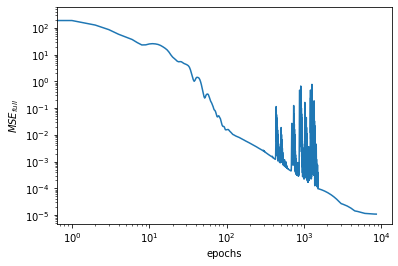

In [35]:
plt.loglog(all_losses)

plt.xlabel("epochs")
plt.ylabel("$MSE_{full}$")

In [297]:
pred = model(norm_i_feats)
mse_full([torch.from_numpy(i_ham.astype(np.float64))], pred, [i_frame], orbs)

tensor(4.7829e-16, grad_fn=<MeanBackward0>)

### Training with loss on eigenvalues

In [47]:
model = LinearModel(i_focks, i_feats)
optimizer = torch.optim.Adam(model.parameters(), lr=0.8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.01)

eigval_losses = []
for epoch in range(30000):
    optimizer.zero_grad()
    pred = model(i_feats[0])
    eigval_loss = mse_eigvals([torch.from_numpy(i_ham.astype(np.float64))], pred, [i_frame], orbs)
    eigval_loss.backward()
    optimizer.step()
    
    eigval_losses.append(eigval_loss.item())

    if epoch % 1000 == 0:
        print(epoch, eigval_loss.item())
    
    scheduler.step()

0 0.07313249260187149
1000 0.00026996646192856133
2000 5.596232099946974e-08
3000 2.7129460719479796e-14
4000 2.6957009893616504e-15
5000 9.686255856238392e-16
6000 1.296768690488997e-15
7000 3.0241524142196087e-15
8000 4.065183858482403e-15
9000 4.32505907241418e-15
10000 4.389821093978875e-15
11000 6.49571885436549e-16
12000 1.186469648284318e-15
13000 1.9500161695210376e-15
14000 1.2387532863491818e-15
15000 1.461137551486062e-15
16000 1.8999177705809715e-15
17000 2.0405432392753145e-15
18000 2.1838470261488756e-15
19000 6.112263439253442e-15
20000 1.3493779068429615e-15
21000 1.7296043264809573e-15
22000 1.7296043264809573e-15
23000 1.7296043264809573e-15
24000 1.7296043264809573e-15
25000 5.531865770003837e-16
26000 5.531865770003837e-16
27000 3.3424373261281472e-15
28000 3.3424373261281472e-15
29000 2.224811445302225e-15


Text(0, 0.5, '$MSE_{\\epsilon}$')

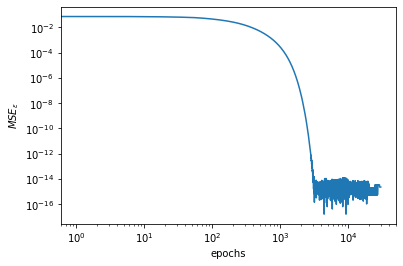

In [48]:
plt.loglog(eigval_losses)

plt.xlabel("epochs")
plt.ylabel("$MSE_{\epsilon}$")

In [49]:
pred_coupled = model(ham_feats)
rmse_full = torch.sqrt(mse_full([torch.from_numpy(i_ham.astype(np.float64))], pred, [i_frame], orbs))
print(rmse_full)

tensor(0.8015, grad_fn=<SqrtBackward0>)


# Train and test on multiple frames

### Split into train and test set

In [32]:
N=len(frames)
train_frames = frames[:int(N/5*4)]
train_hams = hams[:int(N/5*4)]
train_feats = norm_ham_feats.slice(Labels(names=["structure"], values=np.asarray(range(int(N/5*4)), dtype=np.int32).reshape(-1,1)) )
train_focks = fock_bc.slice(Labels(names=["structure"], values=np.asarray(range(int(N/5*4)), dtype=np.int32).reshape(-1,1)) )

In [33]:
test_frames = frames[int(N/5*4):N]
test_hams = hams[int(N/5*4):N]
test_feats = norm_ham_feats.slice(Labels(names=["structure"], values=np.asarray(range(int(N/5*4),N), dtype=np.int32).reshape(-1,1)) )
test_focks = fock_bc.slice(Labels(names=["structure"], values=np.asarray(range(int(N/5*4),N), dtype=np.int32).reshape(-1,1)) )

In [50]:
model = LinearModel(train_focks, train_feats)
optimizer = torch.optim.Adam(model.parameters(), lr=0.8)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.1)

all_losses = []
for epoch in range(30000):
    optimizer.zero_grad()
    pred = model(train_feats)
    loss = mse_full(torch.from_numpy(train_hams.astype(np.float64)), pred, train_frames, orbs)
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    all_losses.append(loss.item())
    
    if epoch % 500 == 0:
        print(epoch, loss.item()) 
#     if loss.item <1e-15: 
#         break 

0 257.47174072265625
500 0.21207232773303986
1000 0.13319097459316254
1500 0.10059145092964172
2000 0.08388348668813705
2500 0.07197120785713196
3000 0.06502241641283035
3500 0.06480200588703156
4000 0.0591096468269825
4500 0.07637953013181686
5000 0.05979904904961586
5500 0.06618069857358932
6000 0.0643850564956665
6500 0.10916924476623535
7000 0.05295393243432045


KeyboardInterrupt: 

0.2163412444054862 eV rmse on TRAIN H prediction


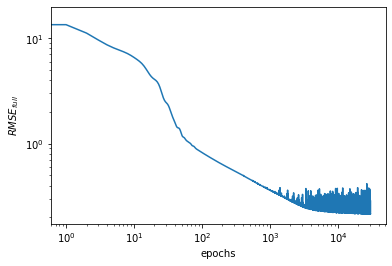

In [36]:
plt.loglog(np.sqrt(all_losses))

plt.xlabel("epochs")
plt.ylabel("$RMSE_{full}$")
print(np.sqrt(all_losses[-1]), "eV rmse on TRAIN H prediction")

In [51]:
pred_all = model(norm_ham_feats.slice(Labels(names=["structure"], values=np.asarray(range(N), dtype=np.int32).reshape(-1,1)) ))
all_loss = mse_full(torch.from_numpy(hams[:N].astype(np.float64)), pred_all, frames[:N], orbs)
print(torch.sqrt(all_loss), "eV rmse on ALL H prediction")
# test_loss_eigvals = mse_eigvals(torch.from_numpy(test_hams.astype(np.float64)), pred_test, test_frames, orbs)

tensor(0.3156, grad_fn=<SqrtBackward0>) eV rmse on ALL H prediction


In [52]:
###TEMPORARY FIX to reindex just the test frames 
pred_test = model(test_feats)
bvalues = []
for i, b in pred_test:
    newblock = TensorBlock(
                        values=b.values,
                        samples=pred.block(i).samples[:len(b.values)],
                        components=b.components,
                        properties= b.properties)
                    
    bvalues.append(newblock) 
        
reindexed_pred_test  = TensorMap(test_focks.keys, bvalues)

In [53]:
test_loss = mse_full(torch.from_numpy(test_hams.astype(np.float64)), reindexed_pred_test, test_frames, orbs)
test_loss_eigvals = mse_eigvals(torch.from_numpy(test_hams.astype(np.float64)), reindexed_pred_test, test_frames, orbs)
print(torch.sqrt(test_loss)*Hartree,  "eV rmse on TEST H prediction")
print(torch.sqrt(test_loss_eigvals),  "eV rmse on TEST eigen prediction")

tensor(13.4387, grad_fn=<MulBackward0>) eV rmse on TEST H prediction
tensor(0.0400, grad_fn=<SqrtBackward0>) eV rmse on TEST eigen prediction


## Training on eigenvalue loss

In [39]:
model = LinearModel(train_focks, train_feats)
optimizer = torch.optim.Adam(model.parameters(), lr=0.8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=13000, gamma=0.1)

all_eigval_losses = []
for epoch in range(30000):
    optimizer.zero_grad()
    pred = model(train_feats)
    loss = mse_eigvals(torch.from_numpy(train_hams.astype(np.float64)), pred, train_frames, orbs)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    all_eigval_losses.append(loss.item())
    
    if epoch % 500 == 0:
        print(epoch, loss.item())

0 14.303984642028809
500 0.015502634458243847
1000 0.01042005605995655
1500 0.008781644515693188
2000 0.007728266529738903
2500 0.00692573469132185
3000 0.00655928160995245
3500 0.006363359745591879
4000 0.0060005635023117065
4500 0.005662913899868727
5000 0.005575426388531923
5500 0.0055769928731024265
6000 0.005534708965569735
6500 0.005525393411517143
7000 0.005460110493004322
7500 0.005366878118366003
8000 0.00537063367664814
8500 0.0053772395476698875
9000 0.00503893569111824
9500 0.0050056250765919685
10000 0.005015129689127207
10500 0.004990844521671534
11000 0.004955752287060022
11500 0.004939895123243332
12000 0.004925692919641733
12500 0.005066752899438143
13000 0.0049745915457606316
13500 0.004914585500955582
14000 0.0049145761877298355
14500 0.004914574325084686
15000 0.004914566408842802
15500 0.004914562217891216
16000 0.00491455290466547
16500 0.004914555232971907
17000 0.00491455290466547
17500 0.004914555232971907
18000 0.004914592485874891
18500 0.0049169971607625484


In [40]:
pred_test = model(test_feats)
bvalues = []
for i, b in pred_test:
    newblock = TensorBlock(
                        values=b.values,
                        samples=pred.block(i).samples[:len(b.values)],
                        components=b.components,
                        properties= b.properties)
                    
    bvalues.append(newblock) 
        
reindexed_pred_test  = TensorMap(test_focks.keys, bvalues)

In [44]:
test_loss = mse_full(torch.from_numpy(test_hams.astype(np.float64)), reindexed_pred_test, test_frames, orbs)
test_loss_eigvals = mse_eigvals(torch.from_numpy(test_hams.astype(np.float64)), reindexed_pred_test, test_frames, orbs)
print(torch.sqrt(test_loss),  "eV rmse on TEST H prediction")
print(torch.sqrt(test_loss_eigvals),  "eV rmse on TEST eigen prediction")

tensor(20.5113, grad_fn=<SqrtBackward0>) eV rmse on TEST H prediction
tensor(0.1081, grad_fn=<SqrtBackward0>) eV rmse on TEST eigen prediction


## Training on combined loss

In [47]:
model = LinearModel(train_focks, train_feats)
optimizer = torch.optim.Adam(model.parameters(), lr=0.8)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.1)

all_eigval_losses = []
all_losses = []
combined_loss = []
for epoch in range(30000):
    optimizer.zero_grad()
    pred = model(train_feats)
    eva_loss = mse_eigvals(torch.from_numpy(train_hams.astype(np.float64)), pred, train_frames, orbs)
    full_loss = mse_full(torch.from_numpy(train_hams.astype(np.float64)), pred, train_frames, orbs)
    loss_combined = eva_loss + full_loss
    loss_combined.backward()
    optimizer.step()
    #scheduler.step()
    
    all_eigval_losses.append(eva_loss.item())
    all_losses.append(full_loss.item())
    combined_loss.append(loss_combined.item())
    
    if epoch % 500 == 0:
        print(epoch, loss_combined.item(), eva_loss.item(), full_loss.item())

0 271.7757263183594 14.303984642028809 257.47174072265625
500 0.2161923497915268 0.00329004880040884 0.21290230751037598
1000 0.13379572331905365 0.001715355203486979 0.13208036124706268
1500 0.10165929794311523 0.0011383050587028265 0.10052099078893661
2000 0.0890539139509201 0.0008536343229934573 0.08820027858018875
2500 0.07346174865961075 0.0006203782395459712 0.07284136861562729
3000 0.06737685203552246 0.00053445715457201 0.06684239208698273
3500 0.07036161422729492 0.0006074538105167449 0.06975416094064713
4000 0.060074981302022934 0.00045490326010622084 0.05962007865309715
4500 0.05530508607625961 0.0004004236834589392 0.05490466207265854
5000 0.056435056030750275 0.0004728602070827037 0.05596219748258591
5500 0.052778154611587524 0.0003673866158351302 0.05241076648235321
6000 0.05830500274896622 0.0005917669041082263 0.057713236659765244
6500 0.060162000358104706 0.00048526987666264176 0.05967672914266586
7000 0.05081114545464516 0.0003586697275750339 0.050452474504709244
7500

KeyboardInterrupt: 

In [48]:
pred_test = model(test_feats)
bvalues = []
for i, b in pred_test:
    newblock = TensorBlock(
                        values=b.values,
                        samples=pred.block(i).samples[:len(b.values)],
                        components=b.components,
                        properties= b.properties)
                    
    bvalues.append(newblock) 
        
reindexed_pred_test  = TensorMap(test_focks.keys, bvalues)

In [49]:
test_loss = mse_full(torch.from_numpy(test_hams.astype(np.float64)), reindexed_pred_test, test_frames, orbs)
test_loss_eigvals = mse_eigvals(torch.from_numpy(test_hams.astype(np.float64)), reindexed_pred_test, test_frames, orbs)
print(torch.sqrt(test_loss),  "eV rmse on TEST H prediction")
print(torch.sqrt(test_loss_eigvals),  "eV rmse on TEST eigen prediction")

tensor(0.4831, grad_fn=<SqrtBackward0>) eV rmse on TEST H prediction
tensor(0.0405, grad_fn=<SqrtBackward0>) eV rmse on TEST eigen prediction
